 # 深度卷积神经网络（AlexNet） 

LeNet:  在大的真实数据集上的表现并不尽如⼈意。     
1.神经网络计算复杂。  
2.还没有⼤量深⼊研究参数初始化和⾮凸优化算法等诸多领域。  
  
机器学习的特征提取:手工定义的特征提取函数  
神经网络的特征提取：通过学习得到数据的多级表征，并逐级表⽰越来越抽象的概念或模式。  
  
神经网络发展的限制:数据、硬件

### AlexNet
首次证明了学习到的特征可以超越⼿⼯设计的特征，从而⼀举打破计算机视觉研究的前状。   
**特征：**
1. 8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。
2. 将sigmoid激活函数改成了更加简单的ReLU激活函数。
3. 用Dropout来控制全连接层的模型复杂度。
4. 引入数据增强，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。

![Image Name](https://cdn.kesci.com/upload/image/q5kv4gpx88.png?imageView2/0/w/640/h/640)



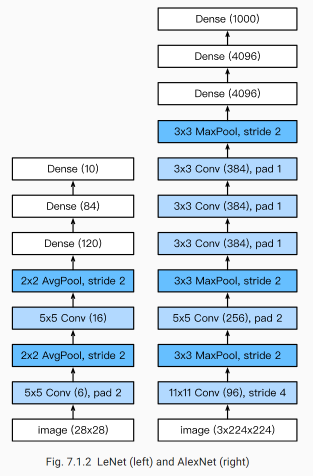

In [1]:
#目前GPU算力资源预计17日上线，在此之前本代码只能使用CPU运行。
#考虑到本代码中的模型过大，CPU训练较慢，
#我们还将代码上传了一份到 https://www.kaggle.com/boyuai/boyu-d2l-modernconvolutionalnetwork
#如希望提前使用gpu运行请至kaggle。


import time
import torch
from torch import nn, optim
import torchvision
import numpy as np
import sys
sys.path.append("/home/kesci/input/") 
import d2lzh1981 as d2l
import os
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            #由于使用CPU镜像，精简网络，若为GPU镜像可添加该层
            #nn.Linear(4096, 4096),
            #nn.ReLU(),
            #nn.Dropout(0.5),

            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):

        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [2]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)


### 载入数据集

In [3]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root='/home/kesci/input/FashionMNIST2065'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter

#batchsize=128
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_fashion_mnist(batch_size,224)
for X, Y in train_iter:
    print('X =', X.shape,
        '\nY =', Y.type(torch.int32))
    break
    

X = torch.Size([16, 1, 224, 224]) 
Y = tensor([5, 2, 9, 3, 1, 8, 3, 3, 2, 6, 1, 6, 2, 4, 4, 8], dtype=torch.int32)


### 训练

In [4]:
lr, num_epochs = 0.001, 3
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

#  使用重复元素的网络（VGG）
VGG：通过重复使⽤简单的基础块来构建深度模型。  
Block:数个相同的填充为1、窗口形状为$3\times 3$的卷积层,接上一个步幅为2、窗口形状为$2\times 2$的最大池化层。  
卷积层保持输入的高和宽不变，而池化层则对其减半。


![Image Name](https://cdn.kesci.com/upload/image/q5l6vut7h1.png?imageView2/0/w/640/h/640)

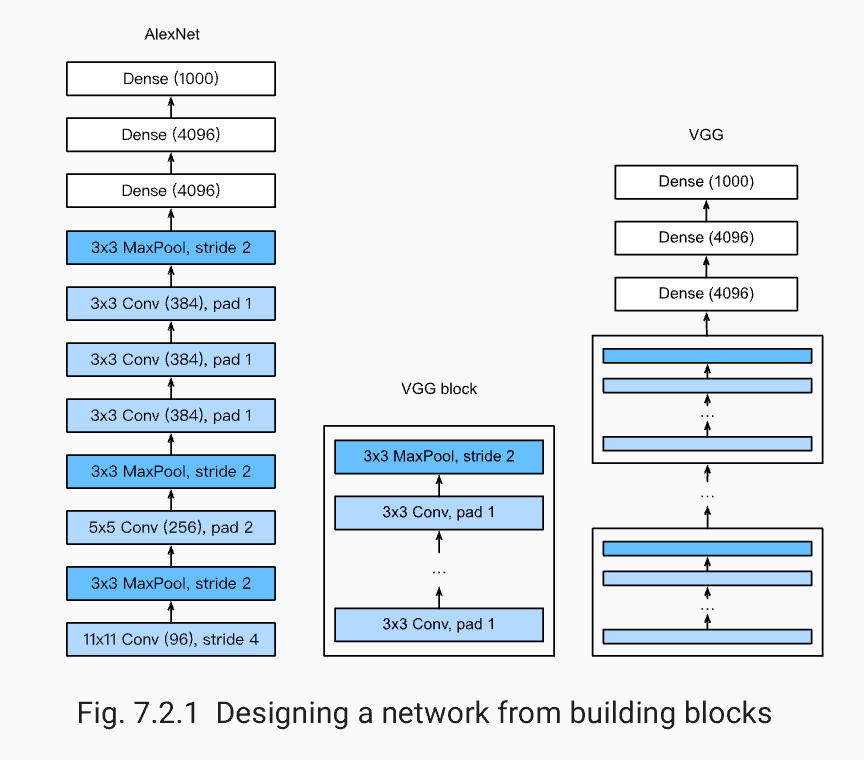

### VGG11的简单实现

In [4]:

def vgg_block(num_convs, in_channels, out_channels): #卷积层个数，输入通道数，输出通道数
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

In [5]:
conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 512 * 7 * 7 # c * w * h
fc_hidden_units = 4096 # 任意

In [6]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(d2l.FlattenLayer(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net

In [7]:
net = vgg(conv_arch, fc_features, fc_hidden_units)
X = torch.rand(1, 1, 224, 224)

# named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)
for name, blk in net.named_children(): 
    X = blk(X)
    print(name, 'output shape: ', X.shape)

vgg_block_1 output shape:  torch.Size([1, 64, 112, 112])
vgg_block_2 output shape:  torch.Size([1, 128, 56, 56])
vgg_block_3 output shape:  torch.Size([1, 256, 28, 28])
vgg_block_4 output shape:  torch.Size([1, 512, 14, 14])
vgg_block_5 output shape:  torch.Size([1, 512, 7, 7])
fc output shape:  torch.Size([1, 10])


In [8]:
ratio = 8
small_conv_arch = [(1, 1, 64//ratio), (1, 64//ratio, 128//ratio), (2, 128//ratio, 256//ratio), 
                   (2, 256//ratio, 512//ratio), (2, 512//ratio, 512//ratio)]
net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units // ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
batchsize=16
#batch_size = 64
# 如出现“out of memory”的报错信息，可减小batch_size或resize
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

#  ⽹络中的⽹络（NiN） 
LeNet、AlexNet和VGG：先以由卷积层构成的模块充分抽取 空间特征，再以由全连接层构成的模块来输出分类结果。  
NiN：串联多个由卷积层和“全连接”层构成的小⽹络来构建⼀个深层⽹络。  
⽤了输出通道数等于标签类别数的NiN块，然后使⽤全局平均池化层对每个通道中所有元素求平均并直接⽤于分类。  

![Image Name](https://cdn.kesci.com/upload/image/q5l6u1p5vy.png?imageView2/0/w/960/h/960)

1×1卷积核作用   
1.放缩通道数：通过控制卷积核的数量达到通道数的放缩。  
2.增加非线性。1×1卷积核的卷积过程相当于全连接层的计算过程，并且还加入了非线性激活函数，从而可以增加网络的非线性。  
3.计算参数少   
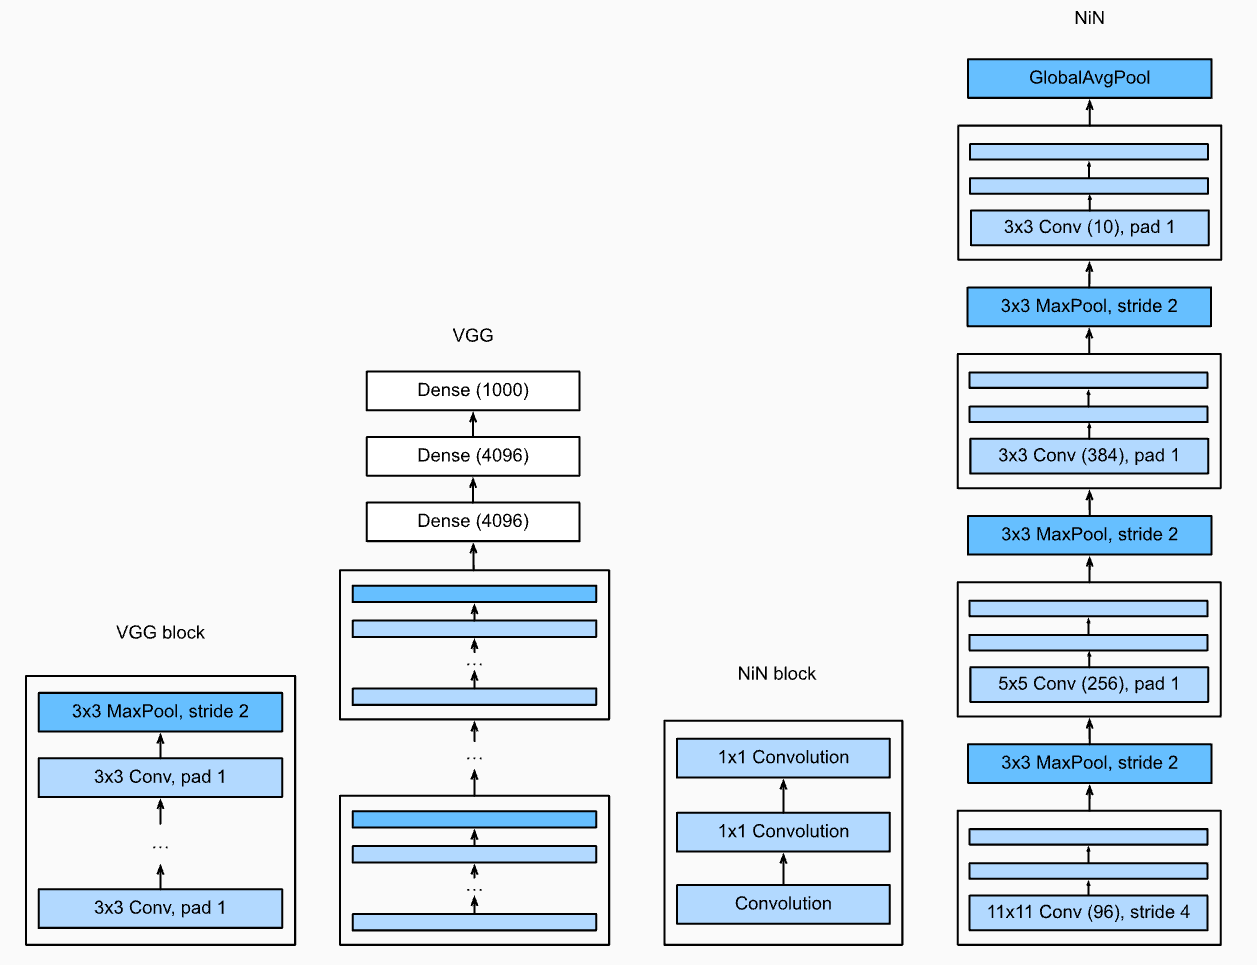

In [9]:

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU())
    return blk

In [10]:
# 已保存在d2lzh_pytorch
class GlobalAvgPool2d(nn.Module):
    # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    GlobalAvgPool2d(), 
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    d2l.FlattenLayer())

In [11]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children(): 
    X = blk(X)
    print(name, 'output shape: ', X.shape)

0 output shape:  torch.Size([1, 96, 54, 54])
1 output shape:  torch.Size([1, 96, 26, 26])
2 output shape:  torch.Size([1, 256, 26, 26])
3 output shape:  torch.Size([1, 256, 12, 12])
4 output shape:  torch.Size([1, 384, 12, 12])
5 output shape:  torch.Size([1, 384, 5, 5])
6 output shape:  torch.Size([1, 384, 5, 5])
7 output shape:  torch.Size([1, 10, 5, 5])
8 output shape:  torch.Size([1, 10, 1, 1])
9 output shape:  torch.Size([1, 10])


In [14]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
#train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.002, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

NiN重复使⽤由卷积层和代替全连接层的1×1卷积层构成的NiN块来构建深层⽹络。  
NiN去除了容易造成过拟合的全连接输出层，而是将其替换成输出通道数等于标签类别数 的NiN块和全局平均池化层。   
NiN的以上设计思想影响了后⾯⼀系列卷积神经⽹络的设计。  

# GoogLeNet
1. 由Inception基础块组成。  
2. Inception块相当于⼀个有4条线路的⼦⽹络。它通过不同窗口形状的卷积层和最⼤池化层来并⾏抽取信息，并使⽤1×1卷积层减少通道数从而降低模型复杂度。   
3. 可以⾃定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。 

![Image Name](https://cdn.kesci.com/upload/image/q5l6uortw.png?imageView2/0/w/640/h/640)

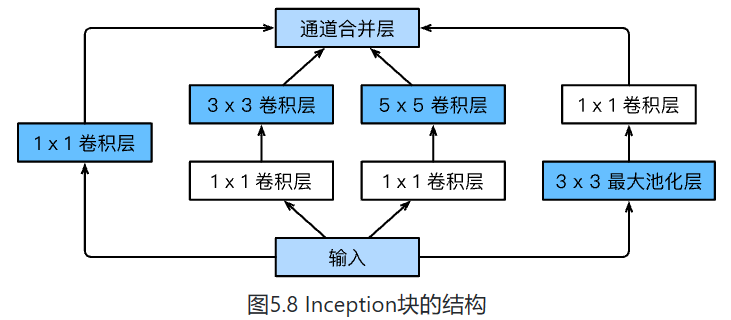

In [12]:

class Inception(nn.Module):
    # c1 - c4为每条线路里的层的输出通道数
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

### GoogLeNet模型
完整模型结构  

![Image Name](https://cdn.kesci.com/upload/image/q5l6x0fyyn.png?imageView2/0/w/640/h/640)

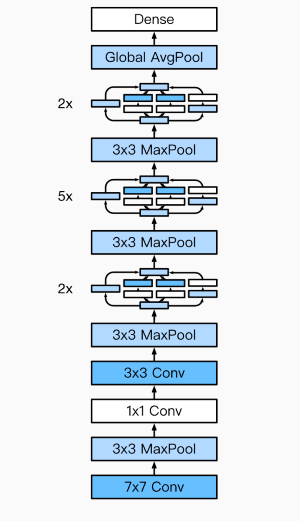

In [16]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   d2l.GlobalAvgPool2d())

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    d2l.FlattenLayer(), nn.Linear(1024, 10))

net = nn.Sequential(b1, b2, b3, b4, b5, d2l.FlattenLayer(), nn.Linear(1024, 10))

X = torch.rand(1, 1, 96, 96)

for blk in net.children(): 
    X = blk(X)
    print('output shape: ', X.shape)

#batchsize=128
batch_size = 16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
#train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)